# Simple regression with bayesian neural networks

In this notebook you will find a comparison between two bayesian methods to assess uncertainty when dealing with neural networks: **Monte-Carlo Dropout** (["Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning"](https://arxiv.org/abs/1506.02142)) and **Bayesian by Backpropagation** (["Weight Uncertainty in Neural Networks"](https://arxiv.org/abs/1505.05424)). We study a very simple toy regression model in 1D.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('retina')
plt.style.use('ggplot')

import torch
from torch.utils import data

## 0. Data preparation

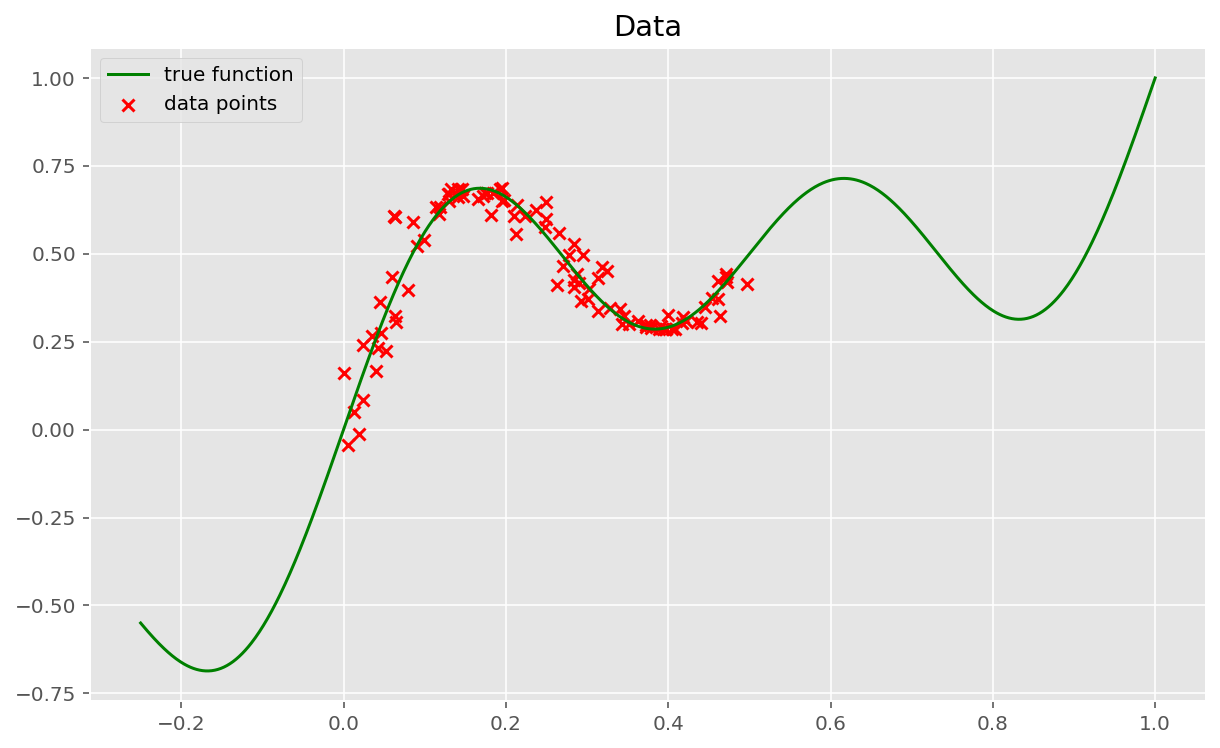

In [2]:
N = 100  #number of training data points
sigma = 0.02
dataset = {}

def function(x, epsilon):
    return x + 0.3 * np.sin(2 * np.pi * (x + epsilon)) + 0.3 * np.sin(4 * np.pi * (x + epsilon)) + epsilon

dataset['X_train'] = np.random.uniform(0, 0.5, N)
dataset['y_train'] = function(dataset['X_train'], np.random.normal(0, sigma, N))

dataset['X_test'] = np.linspace(-0.25, 1, 1000)
F = function(dataset['X_test'], 0)

plt.figure(figsize=(10, 6))
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.scatter(dataset['X_train'], dataset['y_train'], marker='x', color='red', label='data points')
plt.legend()
plt.title("Data")
plt.show()

In [3]:
X_train_tensor = torch.from_numpy(dataset['X_train'].copy()).float().unsqueeze(dim=1)
y_train_tensor = torch.from_numpy(dataset['y_train'].copy()).float()
X_test_tensor = torch.from_numpy(dataset['X_test'].copy()).float().unsqueeze(dim=1)

## 1. Deterministic regression

In [4]:
import models.regression.deterministic_regression as dreg

##### Definition of the model

In [5]:
net = dreg.DeterministicNet(hidden_size=100, dim_input=1, dim_output=1)
reg_model = dreg.DeterministicReg(X_train_tensor, y_train_tensor, X_test_tensor, net)

##### Training step

In [6]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)
reg_model.train(5000, optimizer, criterion, batch=False)

##### Test step

In [7]:
y_pred = reg_model.predict()

##### Plot results

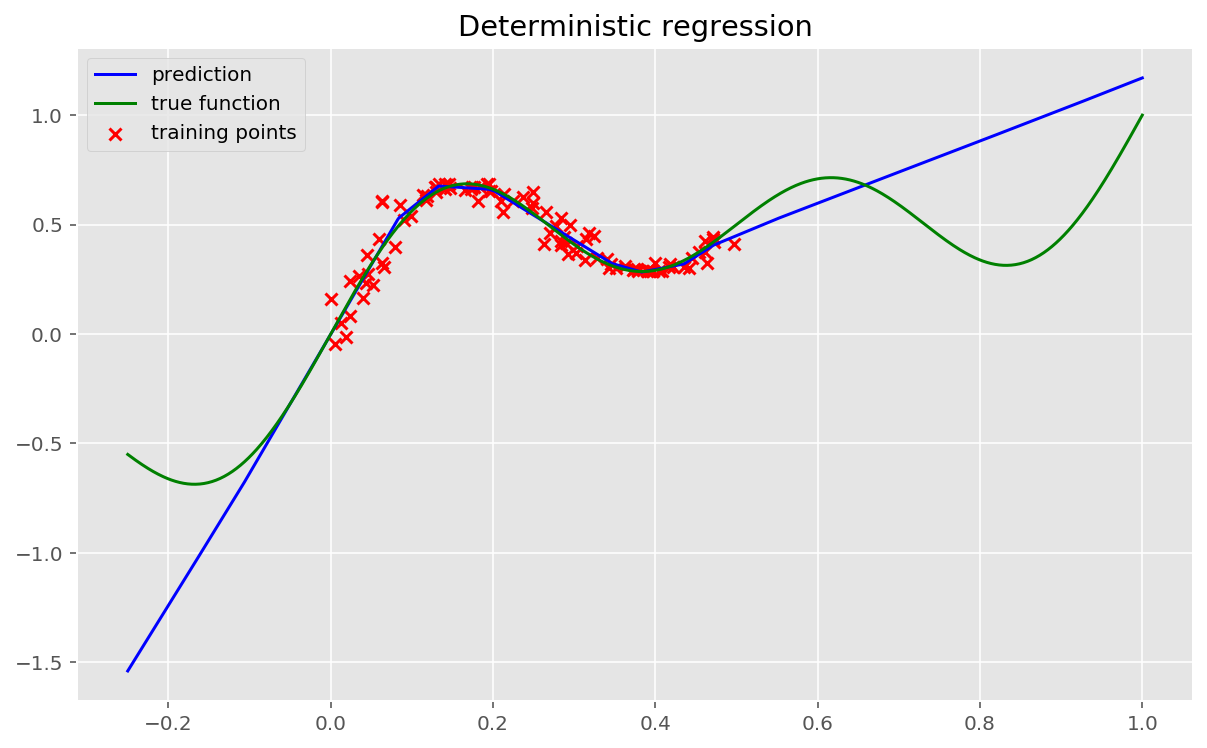

In [8]:
plt.figure(figsize=(10, 6))
reg_model.plot_results()
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.legend()
plt.title('Deterministic regression')
plt.show()

##### Plot weights distribution

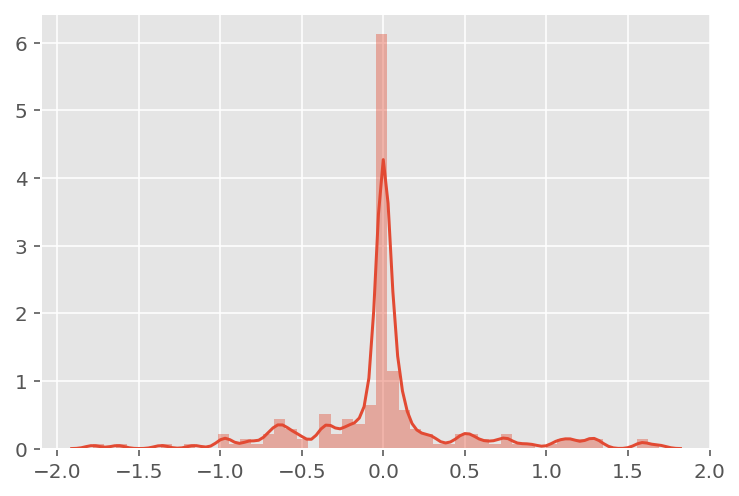

In [9]:
sns.distplot(net.weights_dist())

## 2. Bayesian regression with Monte-Carlo dropout

In [10]:
import models.regression.dropout_regression as doreg

##### Definition of the model

In [11]:
net = doreg.DropoutNet(hidden_size=100, dim_input=1, dim_output=1, p=0.25)
reg_model = doreg.DropoutReg(X_train_tensor, y_train_tensor, X_test_tensor, net, batch_size=X_train_tensor.shape[0])

##### Training step

In [12]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-6)
reg_model.train(5000, optimizer, criterion)

##### Test step

In [13]:
y_pred_mean, y_pred_std = reg_model.predict(samples=1000)

##### Plot results

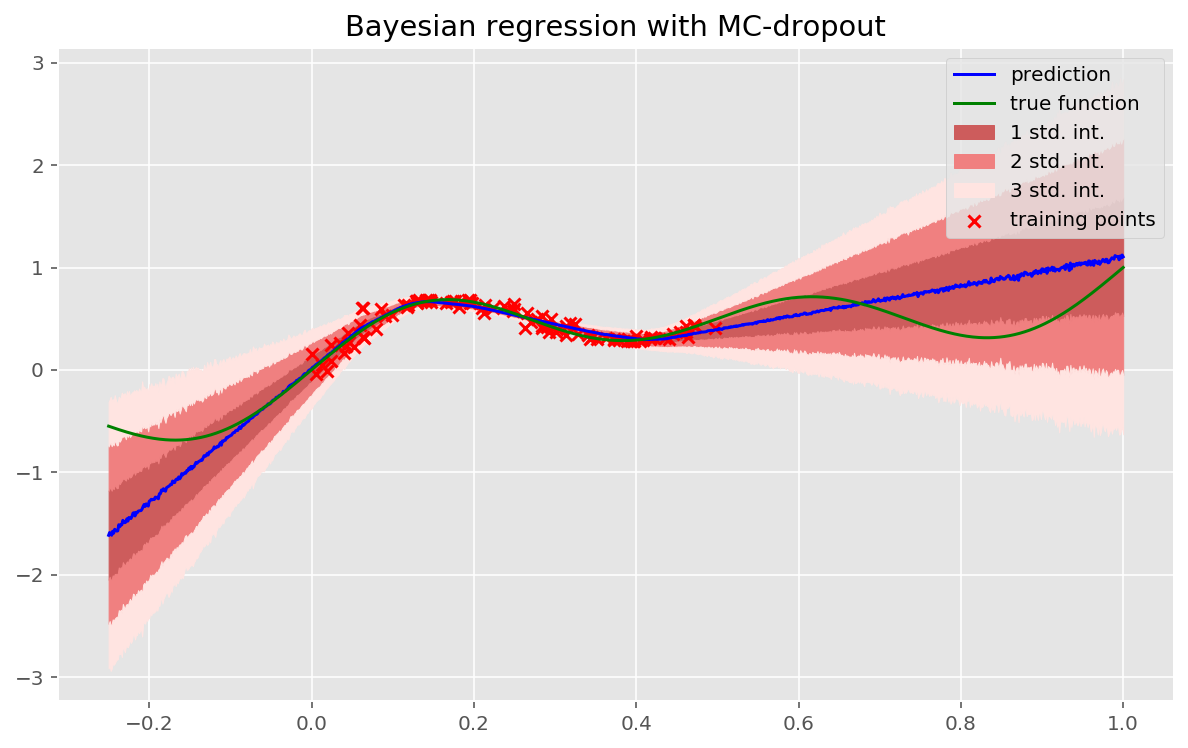

In [14]:
plt.figure(figsize=(10, 6))
reg_model.plot_results()
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.legend()
plt.title("Bayesian regression with MC-dropout")
plt.show()

##### Plot weights distribution

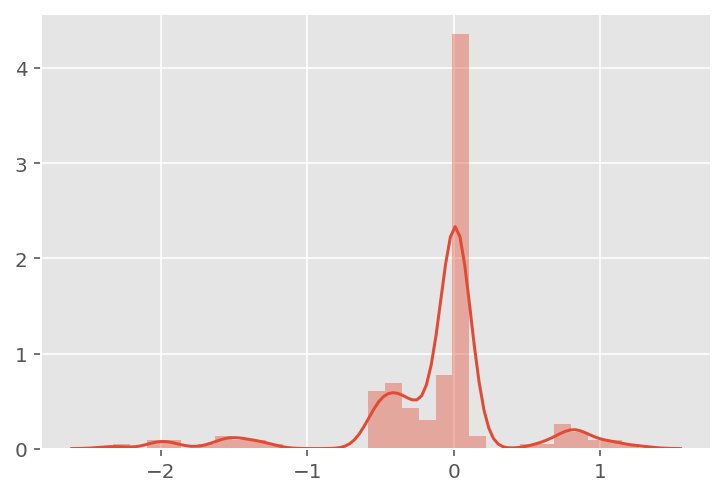

In [15]:
sns.distplot(net.weights_dist())
plt.show()

## 3. Bayesian regression with Bayesian by Backpropagation

In [16]:
import models.regression.bayesbackprop_regression as bbb

##### Definition of the model

In [17]:
prior_parameters = {'sigma1': np.exp(0), 'sigma2': np.exp(-6), 'pi': 0.5}
net = bbb.BayesBackpropNet(hidden_size=64, dim_input=1, dim_output=1, prior_parameters=prior_parameters, sigma=0.06)
reg_model = bbb.BayesBackpropReg(X_train_tensor, y_train_tensor, X_test_tensor, net, batch_size=10)

##### Training step

In [18]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-6)
reg_model.train(3000 , optimizer , 2 , weights = 'geometric')

Epoch:  100/3000, elbo loss =  36595.5, KL =    287.2, -log-likelihood = 36308.3
Epoch:  200/3000, elbo loss =   6972.8, KL =    307.4, -log-likelihood = 6665.3
Epoch:  300/3000, elbo loss =   2650.7, KL =    311.1, -log-likelihood = 2339.6
Epoch:  400/3000, elbo loss =   1052.5, KL =    322.3, -log-likelihood =  730.1
Epoch:  500/3000, elbo loss =    838.7, KL =    321.2, -log-likelihood =  517.5
Epoch:  600/3000, elbo loss =   1219.6, KL =    326.5, -log-likelihood =  893.1
Epoch:  700/3000, elbo loss =    607.2, KL =    332.0, -log-likelihood =  275.2
Epoch:  800/3000, elbo loss =    512.7, KL =    339.4, -log-likelihood =  173.3
Epoch:  900/3000, elbo loss =    355.2, KL =    338.9, -log-likelihood =   16.3
Epoch: 1000/3000, elbo loss =    281.7, KL =    341.1, -log-likelihood =  -59.4
Epoch: 1100/3000, elbo loss =    234.4, KL =    334.1, -log-likelihood =  -99.7
Epoch: 1200/3000, elbo loss =    222.1, KL =    325.0, -log-likelihood = -103.0
Epoch: 1300/3000, elbo loss =    202.8,

##### Test step

In [19]:
y_pred_mean, y_pred_std = reg_model.predict(samples=1000)

##### Plot results

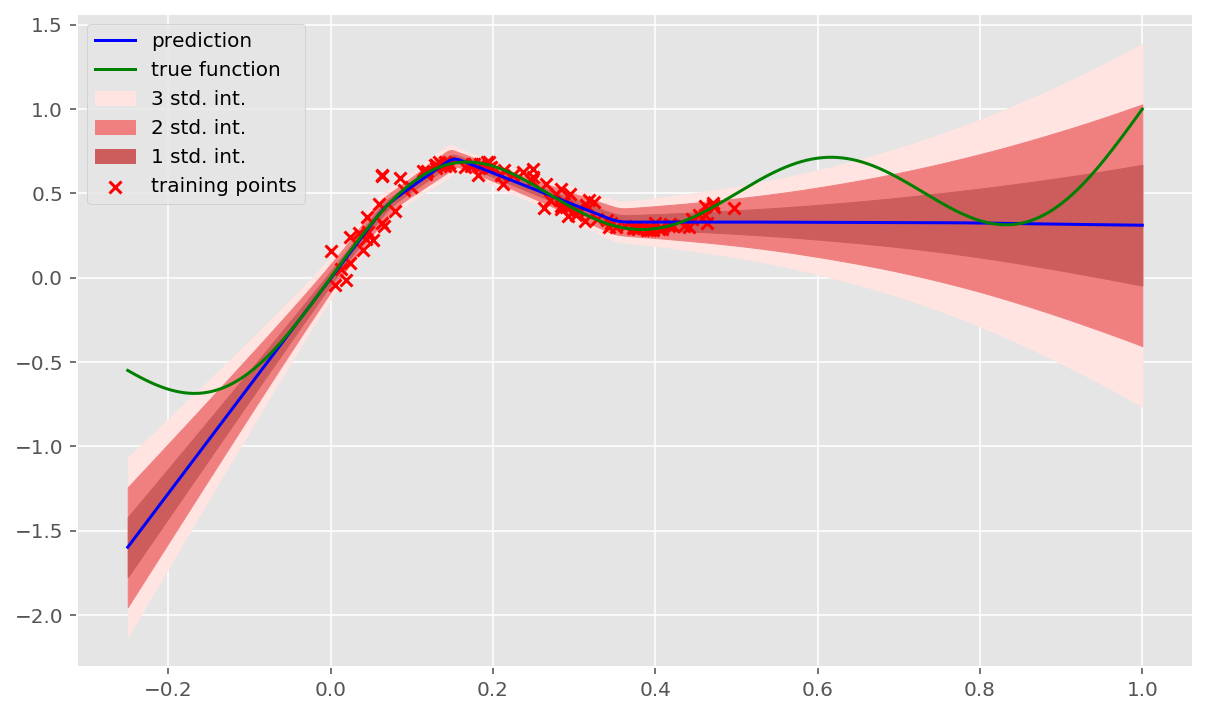

In [20]:
plt.figure(figsize=(10, 6))
reg_model.plot_results()
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.legend()
plt.show()

##### Plot weights distribution

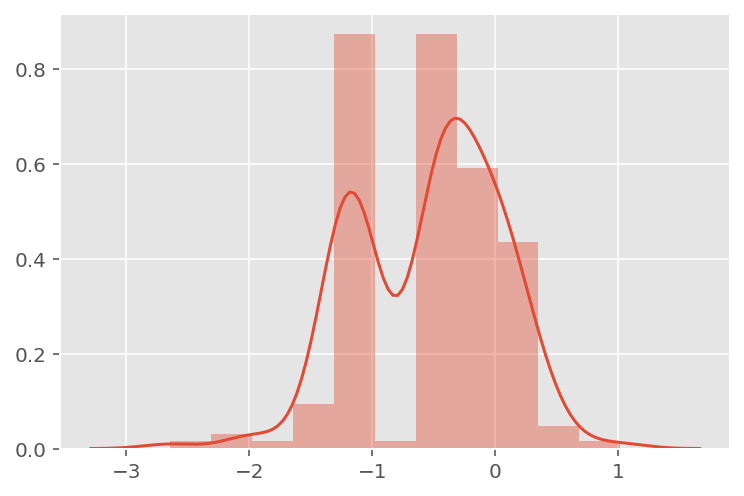

In [21]:
sns.distplot(net.weights_dist())
plt.show()